In [1]:
import seaborn as sns
import tifffile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
predictions = np.load("/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/prediction_all_genes_mu.npz")["prediction"]
truth_test = np.load(f"/net/mulan/home/huiwann/spatial/SVC/data/merfish_U2OS/test_merfish_U2OS.npz")["data_ori"]
truth_train = np.load(f"/net/mulan/home/huiwann/spatial/SVC/data/merfish_U2OS/train_merfish_U2OS.npz")["data_ori"]
print(predictions.shape)

gene_num = predictions.shape[1]

(122, 119, 12, 12)


In [3]:
background_pixel = np.array([[0,0],[0,1],[0,10],[0,11],[1,0],[1,11],[10,0],[10,11],[11,0],[11,1],[11,10],[11,11]], dtype=np.int64)
foreground = np.ones((12, 12), dtype=bool)
foreground[background_pixel[:, 0], background_pixel[:, 1]] = False
foreground_pixels = (foreground==True).sum().item() 


In [ ]:
def make_baselines(predictions,truth_train):
    """
    truth_train: array of shape (n_cells_train, n_genes, H, W)
    return: baseline
    """
    n_cells_train, n_genes, H, W = truth_train.shape
    n_cells_test = predictions.shape[0]

    rand_cells = np.random.randint(0, n_cells_train, size=n_cells_test)        # shape (n_cells,)
    cell_idx = rand_cells[:, None]                                  # (n_cells, 1)
    gene_idx = np.arange(n_genes)[None, :]                          # (1, n_genes)

    # 广播成 (n_cells, n_genes)
    baseline= truth_train[cell_idx, gene_idx, :, :]

    return baseline
    
def cosine_similarity(x1, x2, axis=1, eps=1e-8):
    dot_product = np.sum(x1 * x2, axis=axis)
    norm1 = np.linalg.norm(x1, axis=axis)
    norm2 = np.linalg.norm(x2, axis=axis)
    denom = norm1 * norm2

    cosine_sim = np.where(denom == 0, 0.0, dot_product / (denom + eps))
    return cosine_sim

In [ ]:
from tqdm import tqdm
avg_rmse_SVC = []
avg_cosine_SVC = []
avg_pcc_SVC = []

for i in tqdm(range(gene_num)):
    
    pred_i = predictions[:,i]
    truth_i = truth_test[:,i]
    non_zero_image = truth_i.sum((-1,-2))!=0

    pred_i_flat, truth_i_flat = pred_i.reshape(pred_i.shape[0],-1), truth_i.reshape(truth_i.shape[0],-1)

    pcc_SVC_per_gene = []
    for j in range(truth_i.shape[0]):
        if non_zero_image[j]:
            pcc_SVC_per_gene.append(np.corrcoef(pred_i_flat[j], truth_i_flat[j])[0,1])
    rmse_SVC_per_gene = np.sqrt(np.sum((pred_i_flat - truth_i_flat)**2,axis=1)/foreground_pixels)### pixel求平均
    cosine_SVC_per_gene = cosine_similarity(pred_i_flat, truth_i_flat, axis=1)

    avg_rmse_SVC.append(rmse_SVC_per_gene.mean())### 
    avg_cosine_SVC.append(cosine_SVC_per_gene[non_zero_image].mean())
    avg_pcc_SVC.append(np.array(pcc_SVC_per_gene).mean())

avg_rmse_SVC = np.array(avg_rmse_SVC)
avg_cosine_SVC = np.array(avg_cosine_SVC)
avg_pcc_SVC = np.array(avg_pcc_SVC)

print("avg_rmse_SVC:",avg_rmse_SVC.mean())### 
print("avg_cosine_SVC:",avg_cosine_SVC.mean())
print("avg_pcc_SVC:",avg_pcc_SVC.mean())



  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:00<00:00, 265.74it/s]

avg_rmse_SVC: 1.9853365755997
avg_cosine_SVC: 0.4403636614971317
avg_pcc_SVC: 0.33297599484623996


In [6]:
seeds = [1,2,3,4,5,6,7,8,9,10]
rmse_baseline_repeat = np.zeros((10,gene_num))
cosine_baseline_repeat = np.zeros((10,gene_num))
pcc_baseline_repeat = np.zeros((10,gene_num))


for seed in tqdm(seeds):
    np.random.seed(seed)
    baseline= make_baselines(predictions,truth_train)
    avg_cosine_baseline = []
    avg_pcc_baseline = []
    avg_rmse_baseline = []
    for i in range(gene_num):

        truth_i = truth_test[:,i]
        truth_i_flat =  truth_i.reshape(truth_i.shape[0],-1)
    
        non_zero_image = truth_i.sum((-1,-2))!=0

        baseline_image = baseline[:,i]

        baseline_image_flat = baseline_image.reshape(baseline_image.shape[0],-1)
        
        pcc_baseline = []
        for j in range(truth_i.shape[0]):
            if non_zero_image[j]:
                pcc_baseline.append(np.corrcoef(baseline_image_flat[j], truth_i_flat[j])[0,1])
        cosine_baseline = cosine_similarity(baseline_image.reshape(baseline_image.shape[0],-1), truth_i_flat, axis=1)
        rmse_baseline_per_gene = np.sqrt(np.sum((baseline_image_flat - truth_i_flat)**2,axis=1)/foreground_pixels)

        avg_cosine_baseline.append(cosine_baseline[non_zero_image].mean())
        avg_pcc_baseline.append(np.nanmean(np.array(pcc_baseline)))
        avg_rmse_baseline.append(rmse_baseline_per_gene.mean())

    avg_cosine_baseline = np.array(avg_cosine_baseline)
    avg_pcc_baseline = np.array(avg_pcc_baseline)
    avg_rmse_baseline = np.array(avg_rmse_baseline)
    cosine_baseline_repeat[seed-1,:] = avg_cosine_baseline
    pcc_baseline_repeat[seed-1,:] = avg_pcc_baseline
    rmse_baseline_repeat[seed-1,:] = avg_rmse_baseline


print("avg cosine baseline:",cosine_baseline_repeat.mean())
print("avg pcc baseline:",np.nanmean(pcc_baseline_repeat))
print("avg rmse baseline:",rmse_baseline_repeat.mean())

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

avg cosine baseline: 0.14918149786227106
avg pcc baseline: 0.0596033519529069
avg rmse baseline: 2.9125613996860684


median pcc gain: 0.26283565463460457 0.12706717224520714 0.5213045485602202
median cosine gain: 0.29181980915990435 0.1929304897630557 0.4097130905219764
median rmse gain: 0.2935000150473909 0.23030686499311942 0.3950703611652919


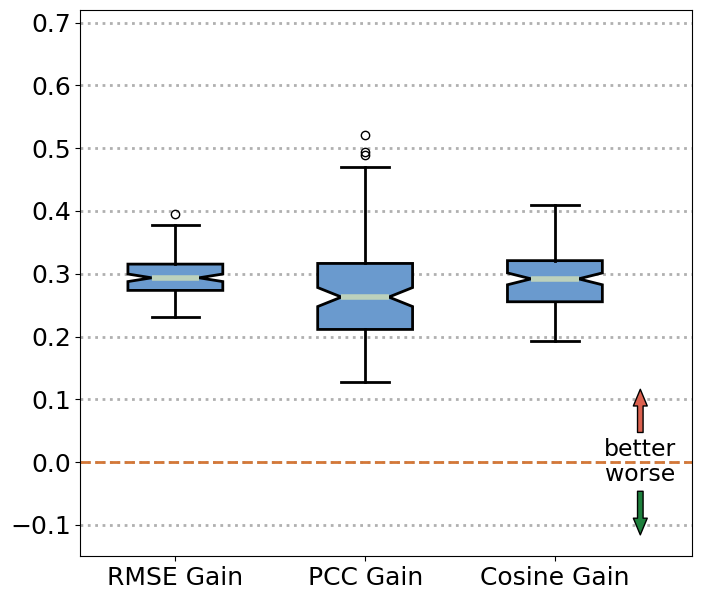

In [7]:

pcc_baseline_avg = pcc_baseline_repeat.mean(axis=0)
cosine_baseline_avg = cosine_baseline_repeat.mean(axis=0)
rmse_baseline_avg = rmse_baseline_repeat.mean(axis=0)
pcc_gain = (avg_pcc_SVC-pcc_baseline_avg)
pcc_gain = pcc_gain[~np.isnan(pcc_gain)]
cosine_gain = (avg_cosine_SVC-cosine_baseline_avg)
rmse_gain = -(avg_rmse_SVC - rmse_baseline_avg)/rmse_baseline_avg

print("median pcc gain:", np.median(pcc_gain),np.min(pcc_gain),np.max(pcc_gain))
print("median cosine gain:", np.median(cosine_gain),np.min(cosine_gain),np.max(cosine_gain))
print("median rmse gain:", np.median(rmse_gain),np.min(rmse_gain),np.max(rmse_gain))

plt.figure(figsize=(7, 6))
plt.boxplot([rmse_gain,pcc_gain,cosine_gain], widths=0.5,zorder=10,#showfliers=False,
    notch=True,
    vert=True,
    patch_artist=True, 
    boxprops=dict(facecolor='#6a9ace', linewidth=2),
    medianprops=dict(linewidth=4,color='#bcd1bc'),
    whiskerprops=dict(color='black', linestyle='-', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='o', markersize=6, linestyle='none')
)

plt.axhline(0, color='#d47838', linestyle='--', linewidth=2)
# plt.axhline(np.median(cosine_gain), color='orange', linestyle='--', linewidth=1)

arrow_x = 3.35

plt.annotate(
    'better',                   
    xy=(arrow_x+0.1, 0.12),           
    xytext=(arrow_x+0.1, 0.01),      
    arrowprops=dict(
        facecolor='#db614f',
        shrink=0.05, 
        width=4,          
        headwidth=10
        # arrowstyle='->',
        # lw=1.5
    ),
    fontsize=17,
    ha='center'
)
plt.annotate(
    'worse',
    xy=(arrow_x+0.1, -0.12),
    xytext=(arrow_x+0.1 , -0.03),
    arrowprops=dict(
        facecolor='#1e803d', 
        shrink=0.05, 
        width=4, 
        headwidth=10),
    fontsize=17,
    ha='center'
)


plt.tight_layout()
plt.xlim(0.5, 3.72)  
plt.ylim(-0.15,0.72) 
plt.xticks([1,2,3],["RMSE Gain","PCC Gain","Cosine Gain"], fontsize=18)
plt.yticks(np.arange(-0.1, 0.8, 0.1),fontsize=18)
plt.grid(axis='y', linestyle=':',linewidth=2)
plt.show()


In [8]:
gene_names = np.loadtxt('/net/mulan/home/huiwann/spatial/SVC/data/merfish_U2OS/gene_names.txt', dtype=str).tolist()

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=2025)

groups = []
for train_index, test_index in kf.split(gene_names):
    groups.append(np.array(gene_names)[test_index])

for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['AGAP1' 'CCDC113' 'IGF2R' 'IL17RA' 'MCF2L' 'NRIP1' 'PLXNA2' 'SAMD12'
 'SMARCA5' 'SPTBN1' 'XDH' 'YIPF4']
Group 2: ['AHDC1' 'AKAP11' 'AMOTL1' 'CDYL2' 'CNR2' 'CRTAP' 'FAF2' 'KLHL9' 'PRKCA'
 'PRPF8' 'RAD51D' 'SLC7A11']
Group 3: ['AFF4' 'ALPK2' 'BSN' 'FASN' 'FBN2' 'GPR107' 'GTF3C4' 'HERC2' 'PHIP'
 'SLC9A2' 'TTPAL' 'UBR2']
Group 4: ['AFAP1' 'ARL10' 'DIP2B' 'FBN1' 'MED14' 'PRDM2' 'SLC35B4' 'SMIM5' 'TNRC6A'
 'TSTD2' 'USP9X' 'USP34']
Group 5: ['AGPS' 'CREBBP' 'EGFR' 'ITPR2' 'LRP1' 'MYH10' 'NHSL2' 'PIK3CA' 'PRKDC'
 'SLC5A3' 'THSD4' 'UMPS']
Group 6: ['ANKH' 'BUB3' 'CBX5' 'CEMIP' 'CHST3' 'KIF13B' 'MAN1A2' 'NKTR' 'SOD2'
 'STARD9' 'TSPAN3' 'USP8']
Group 7: ['DNAJC13' 'KPNA4' 'LMTK2' 'LUZP1' 'POLQ' 'RNF152' 'SLC38A1' 'SSH1' 'TLN1'
 'USP24' 'VPS13D' 'ZNF592']
Group 8: ['BRCA2' 'CBL' 'COL5A1' 'DYNC1H1' 'FAM184B' 'FZD4' 'FZD5' 'HEATR5B'
 'PROSER1' 'PTPN14' 'RNF169' 'THBS1']
Group 9: ['AGO3' 'ANKRD52' 'C14orf132' 'CEP250' 'CKAP5' 'FYCO1' 'PAPPA' 'RBM20'
 'SKP1' 'SULT1C2' 'TPR' 'UBR5']
Group 10:

In [10]:
j=0
for selected_gene in groups:
    gene_to_impute = [gene_names.index(i) for i in selected_gene if i in gene_names]
    rmse_per_gene = np.zeros(len(gene_to_impute))
    for i in range(len(gene_to_impute)):
        real_i = truth_test.sum((-1,-2))[:,gene_to_impute[i]]
        impute_i = predictions.sum((-1,-2))[:,gene_to_impute[i]]
        rmse_per_gene[i] = np.sqrt(np.mean((real_i - impute_i) ** 2))

    np.savetxt(f"/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/compared_methods/SVC/rmse_per_gene_group_{j}.txt", rmse_per_gene)
    j+=1

In [11]:
rmse_per_gene_SVC = np.zeros(len(gene_names))
rmse_per_gene_ENVI = np.zeros(len(gene_names))
rmse_per_gene_gimVI = np.zeros(len(gene_names))
rmse_per_gene_uniPort = np.zeros(len(gene_names))
length = 0
for i, group in enumerate(groups):
    rmse_per_gene_SVC[length:length+len(group)]=np.loadtxt(f"/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/compared_methods/SVC/rmse_per_gene_group_{i}.txt")
    rmse_per_gene_ENVI[length:length+len(group)]=np.loadtxt(f'/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/compared_methods/ENVI/rmse_per_gene_group_{i}.txt')
    rmse_per_gene_gimVI[length:length+len(group)]=np.loadtxt(f"/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/compared_methods/gimVI/rmse_per_gene_group_{i}.txt") 
    rmse_per_gene_uniPort[length:length+len(group)]=np.loadtxt(f'/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/compared_methods/uniPort/rmse_per_gene_group_{i}.txt')
    length += len(group)
    
print("RMSE per gene SVC",np.median(rmse_per_gene_SVC))
print("RMSE per gene ENVI:", np.median(rmse_per_gene_ENVI))
print("RMSE per gene gimVI:", np.median(rmse_per_gene_gimVI))
print("RMSE per gene uniPort:", np.median(rmse_per_gene_uniPort))

RMSE per gene SVC 24.643936318967324
RMSE per gene ENVI: 131.8137370225048
RMSE per gene gimVI: 31.430418349300197
RMSE per gene uniPort: 27.89042410178438


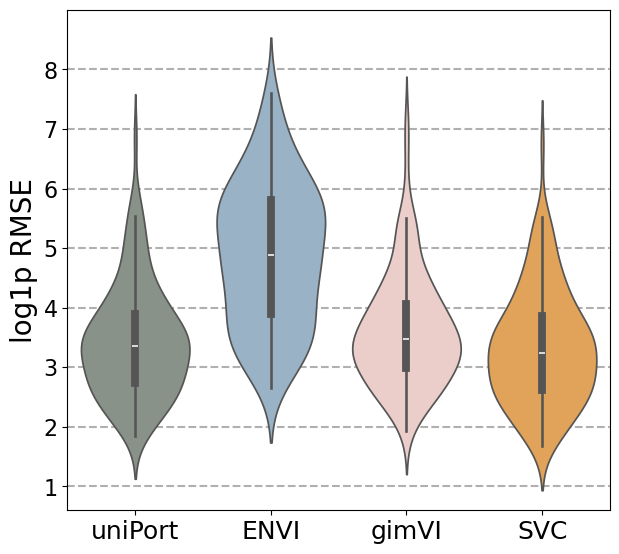

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
colors = ["#879486", "#91b3ce", "#f1cac4", "#f7a444"]
sns.violinplot([np.log1p(rmse_per_gene_uniPort),np.log1p(rmse_per_gene_ENVI), np.log1p(rmse_per_gene_gimVI),np.log1p(rmse_per_gene_SVC)], ax=ax,palette=colors,zorder=2)
for patch, color in zip(ax.artists, colors):     
    patch.set_facecolor(color)
ax.set_ylim(0.6, 9)
ax.set_ylabel('log1p RMSE', fontsize=20)
ax.set_yticks(np.arange(1, 9, 1))
ax.set_yticklabels(np.arange(1, 9, 1), fontsize=16)
ax.set_xticklabels(['uniPort','ENVI', 'gimVI','SVC'], fontsize=18)
plt.grid(axis='y', linestyle='--',linewidth=1.5)